**Todo**:
1. Transform features (must understand the sensor data before
2. Remove unnecessary features (using what? correlation matrix, random forest, pca, ...)
3. Combine different regression models (ensemble model) to evaluate the test dataset
3. Try Deep Learning (Autoencoder, Vanilla... on google colab or on gpu server if you have an access)
4. Look into paperswithcode website for experimental model
5. Think about how to make a learning model explainable for decision
6. Do some EDAs, don't have to be fancy or anything
7. Post random code on the dacon website; uploading a code is part of the grade 


possibly more...

### Import Libraries

In [2]:
!pip install optuna
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 11.7 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 209 kB 49.9 MB/s 
     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 48.2 MB/s 
     |████████████████████████████████| 147 kB 53.8 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1f43eeb8defa6183e05b4e0d3c1b9764ffb0dcf0bd4be81c3d23d3cc425c3915
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# 기본 데이터 정리 및 처리
import pandas as pd
import numpy as np
import random
import os

# 시각화
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 전처리 및 머신 러닝 알고리즘
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection


# 경고 제거 (판다스가 에러 메시지를 자주 만들어 내기 때문)
import warnings
warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### Usable Functions 

In [4]:
# ys = ['Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 
#       'Y_06', 'Y_07', 'Y_08', 'Y_09', 'Y_10', 
#       'Y_11', 'Y_12', 'Y_13', 'Y_14']
# ys_bounds = [[0.2, 2], [0.2, 2.1], [0.2, 2.1], 
#              [7, 19], [22, 36.5], [-19.2, 19], 
#              [2.4, 4], [-29.2, -24], [-29.2, -24],
#              [-30.6, -20], [19.6, 26.6], [-29.2, -24],
#              [-29.2, -24], [-29.2, -24]]

In [5]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Featrue
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

### Load Dataset

In [6]:
train_df = pd.read_csv('data/train.csv')
test_x = pd.read_csv('data/test.csv')
train_x, train_y = dataset_split_X_y(train_df)

train_y_info = pd.read_csv('data/meta/y_feature_spec_info.csv')

### Exploratory Data Analysis

In [7]:
train_x.describe()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
count,39607.000000,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,...,39607.0,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,68.412040,103.320166,68.826354,1.0,102.337203,70.597211,29.407490,164.449320,225.397470,0.002449,...,1.0,1.0,16676.913639,130.774557,131.457418,138.587595,127.992420,128.014110,137.884711,128.441119
std,2.655983,0.000372,5.151167,0.0,0.548353,2.259820,7.338204,220.402444,66.734725,0.086255,...,0.0,0.0,8584.427420,5.989845,5.934313,6.469813,5.713153,5.433958,6.552101,5.444245
min,56.268000,103.320000,56.470000,1.0,101.774000,61.726000,14.140000,38.460000,37.580000,0.000000,...,1.0,1.0,3341.830000,21.800000,21.910000,23.100000,21.330000,21.340000,22.980000,21.410000
25%,66.465000,103.320000,65.070000,1.0,101.949000,68.864000,27.890000,105.990000,188.540000,0.000000,...,1.0,1.0,13093.930000,126.948571,127.669758,134.475401,124.374525,124.697879,133.744103,125.134713
50%,68.504000,103.320000,67.270000,1.0,102.006000,69.884000,28.840000,115.040000,234.450000,0.000000,...,1.0,1.0,15273.330000,130.723378,131.352856,138.525575,128.020010,128.098728,137.900952,128.414501
75%,69.524000,103.320000,71.770000,1.0,103.144000,71.923000,29.870000,132.620000,263.960000,0.000000,...,1.0,1.0,17560.180000,134.538998,135.170761,142.702448,131.618662,131.487423,142.073102,131.839764
max,84.820000,103.321000,89.170000,1.0,103.160000,87.219000,163.860000,2387.440000,637.490000,3.600000,...,1.0,1.0,114563.630000,162.619458,194.513195,173.438623,152.406630,175.052891,170.155980,155.277538


In [8]:
train_y_info.head()

,Feature,최소,최대
0,Y_01,0.2,2.0
1,Y_02,0.2,2.1
2,Y_03,0.2,2.1
3,Y_04,7.0,19.0
4,Y_05,22.0,36.5


In [9]:
train_y.describe()

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,1.353814,1.057267,1.014002,13.621191,31.290467,16.529382,3.155054,-26.294839,-26.308623,-22.400062,24.325061,-26.237762,-26.233869,-26.245868
std,0.356223,0.386266,0.361492,2.686632,2.543222,1.893014,0.418940,0.660537,0.653580,0.920952,0.830197,0.656329,0.655090,0.655989
min,0.017000,0.007000,0.017000,-0.331000,18.589000,-19.963000,0.502000,-29.652000,-29.523000,-31.119000,19.844000,-29.544000,-29.448000,-29.620000
25%,1.127500,0.793000,0.769000,11.822000,29.768000,16.146000,2.863000,-26.689000,-26.702000,-22.871000,23.836000,-26.630000,-26.624000,-26.640000
50%,1.349000,1.044000,0.998000,13.837000,31.710000,16.694000,3.126000,-26.254000,-26.266000,-22.275000,24.420000,-26.198000,-26.193000,-26.204000
75%,1.576000,1.300000,1.239000,15.626000,33.184000,17.164000,3.433500,-25.855000,-25.871000,-21.791000,24.911500,-25.799000,-25.794000,-25.809000
max,4.409000,3.998000,3.756000,98.794000,37.250000,18.998000,5.299000,-23.785000,-23.960000,-20.052000,26.703000,-23.722000,-23.899000,-23.856000


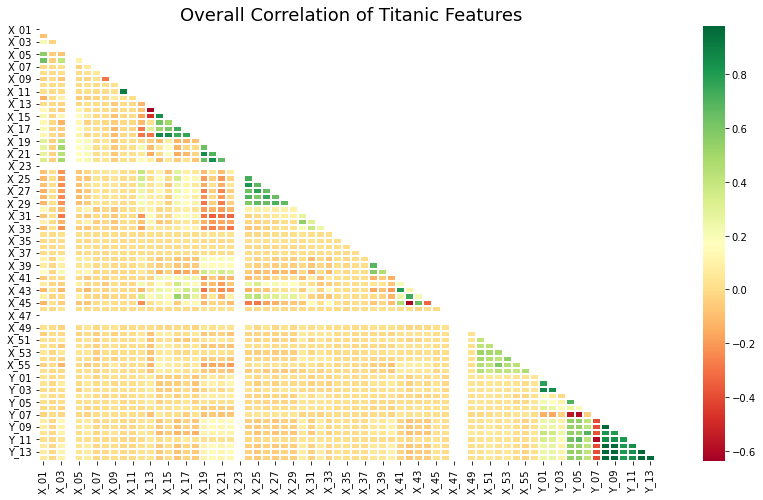

In [8]:
# Co-relation 매트릭스
corr = train_df.corr()
# 마스크 셋업
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 그래프 셋업
plt.figure(figsize=(14, 8))
# 그래프 타이틀
plt.title('Overall Correlation of Titanic Features', fontsize=18)
# Co-relation 매트릭스 런칭
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

In [ ]:
train_df.corrwith(train_df['avg'], method='spearman')

In [122]:
train_df_g1 = train_df.iloc[:, :58]
train_df_g1 = pd.concat([train_df_g1, train_df.iloc[:, 60:61]], axis=1)
train_df_g1 = pd.concat([train_df_g1, train_df.iloc[:, 62:63]], axis=1)
train_df_g1 = pd.concat([train_df_g1, train_df.iloc[:, 64:67]], axis=1)
train_df_g1 = pd.concat([train_df_g1, train_df.iloc[:, 68:71]], axis=1)

In [123]:
train_df_g1.head()

,ID,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,...,X_56,Y_01,Y_04,Y_06,Y_08,Y_09,Y_10,Y_12,Y_13,Y_14
0,TRAIN_00001,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,...,125.028256,2.056,10.502,16.083,-25.381,-25.529,-22.769,-25.470,-25.409,-25.304
1,TRAIN_00002,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,...,124.877308,1.446,18.507,16.736,-26.619,-26.523,-22.574,-26.253,-26.497,-26.438
2,TRAIN_00003,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,...,122.238232,1.251,14.082,17.080,-26.238,-26.216,-22.169,-26.285,-26.215,-26.370
3,TRAIN_00004,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,...,134.875225,1.464,16.975,17.143,-25.426,-25.079,-21.765,-25.254,-25.021,-25.345
4,TRAIN_00005,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,...,123.272762,0.983,15.047,17.569,-25.376,-25.242,-21.072,-25.072,-25.195,-24.974


C:\Users\Dohyeong Seo\AppData\Local\Temp\ipykernel_16080\3332887719.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


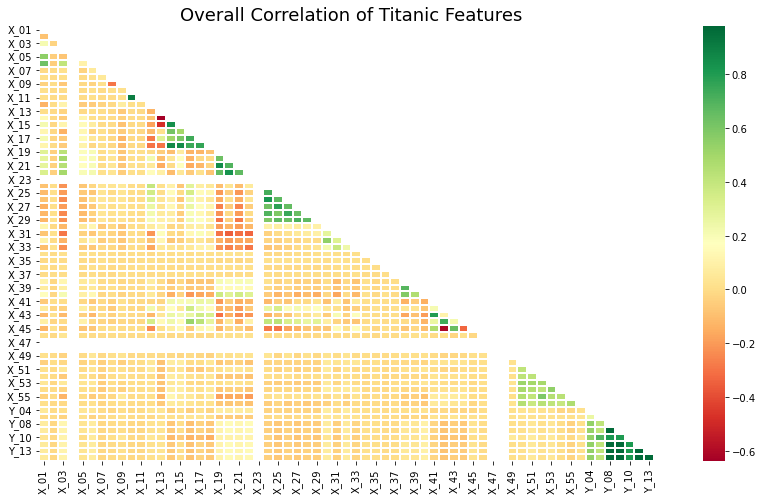

In [96]:
# Co-relation 매트릭스
corr = train_df_g1.corr()
# 마스크 셋업
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 그래프 셋업
plt.figure(figsize=(14, 8))
# 그래프 타이틀
plt.title('Overall Correlation of Titanic Features', fontsize=18)
# Co-relation 매트릭스 런칭
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

In [80]:
### Feature 생성 , y_feature_info 규격 조건 추가

# val = 1 (Spec pass)
# val = 0 (Spec pass fail)

result = []
for idx in range(len(train_y)):
    val = 1
    for i in range(14):
        title, min_, max_ = train_y_info.loc[i]
        if min_ > train_y.loc[idx][i] or max_ < train_y.loc[idx][i]:
            val = 0
            break
    result.append(val)

In [103]:
X_57 = pd.DataFrame(result, columns=['X_57'])
X_57.value_counts()

X_57
1       35690
0        3917
dtype: int64

In [105]:
train_x = pd.concat([train_x, X_57], axis=1)

In [106]:
train_x.head()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,0.0,...,1,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256,0
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,0.0,...,1,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308,1
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,0.0,...,1,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232,1
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,0.0,...,1,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225,1
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,0.0,...,1,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762,1


### Feature Selection


In [ ]:
cols_with_zero_variance = zero_variance(train_x)
train_x = train_x.drop(cols_with_zero_variance, axis = 1)

test_x = test_x.drop(cols_with_zero_variance, axis = 1)

highly_correlated = [i[1] for i in get_top_correlation(train_x, 7).index]
train_x = train_x.drop(highly_correlated, axis = 1)

test_x = test_x.drop(highly_correlated, axis = 1)
test_x = test_x.drop('ID', axis=1)

In [ ]:
# 그룹에 대한 feature selection

In [ ]:
cols_with_zero_variance = zero_variance(train_df_g1)
train_df_g1 = train_df_g1.drop(cols_with_zero_variance, axis = 1)

test_x = test_x.drop(cols_with_zero_variance, axis = 1)

highly_correlated = [i[1] for i in get_top_correlation(train_x, 7).index]
train_df_g1 = train_df_g1.drop(highly_correlated, axis = 1)

test_x = test_x.drop(highly_correlated, axis = 1)
test_x = test_x.drop('ID', axis=1)

### Train
Train dataset is again splitted into train and validation set

In [113]:
def evaluate(params, x_train, y_train, x_test, y_test):
    model = MultiOutputRegressor(LGBMRegressor(objective='regression', n_jobs=-1, **params))
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    nrmse = lg_nrmse(y_test, pred)
    return nrmse

In [114]:
train_X, validation_X, train_Y, validation_Y = train_test_split(train_x, train_y, test_size = 0.2, )


In [115]:
lgb_params_space = {
    'max_depth':        hp.choice('max_depth',        np.arange(3, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 9, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.2, 0.9, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'n_estimators':     100,
    'num_leaves':       50,
    'bagging_fraction': hp.uniform("bagging_fraction", 0, 1.0),
}

In [118]:
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)


[LightGBM] [Warning] feature_fraction is set=0.7509060381588515, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.7509060381588515
[LightGBM] [Warning] bagging_fraction is set=0.06177473934721667, subsample=0.8596430488180139 will be ignored. Current value: bagging_fraction=0.06177473934721667
[LightGBM] [Warning] feature_fraction is set=0.5343366963333515, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.5343366963333515
[LightGBM] [Warning] bagging_fraction is set=0.30832024778516187, subsample=0.8790583590359695 will be ignored. Current value: bagging_fraction=0.30832024778516187
[LightGBM] [Warning] feature_fraction is set=0.6934756080483435, colsample_bytree=0.5000000000000001 will be ignored. Current value: feature_fraction=0.6934756080483435
[LightGBM] [Warning] bagging_fraction is set=0.3641072854435312, subsample=0.8233450774195804 will be ignored. Current value: bagging_fraction=0.3641072854435312
[L

In [119]:
best_params

{'bagging_fraction': 0.03251250232932293,
 'colsample_bytree': 5,
 'feature_fraction': 0.8626722478541968,
 'max_depth': 3,
 'min_child_weight': 4,
 'subsample': 0.8476483729981878}

### Inference

In [ ]:
model = MultiOutputRegressor(LGBMRegressor(**best_params))
model.fit(train_x, train_y)
preds = model.predict(test_x)

In [ ]:
pd.DataFrame(preds)

### Save Prediction

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]